<a href="https://colab.research.google.com/github/javahedi/QuantumStateTomography-ML/blob/main/main_last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split


In [67]:
# Check available devices
devices = tf.config.experimental.list_physical_devices('GPU')  # Check for GPU
if devices:
    print("Using GPU")
    tf.config.experimental.set_visible_devices(devices[0], 'GPU')  # Use the first GPU
else:
    print("Using CPU")

Using CPU


In [68]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [69]:

path         = "/content/drive/MyDrive/SL_data/"
cvs_names    = glob.glob(f'{path}*.csv')
bank_names   = glob.glob(f'{path}*bank.npy')
weight_names = glob.glob(f'{path}*weights.npy')

angles_list  = []
banks_list   = []
weights_list = []
for id, name in enumerate(cvs_names):
    data    = np.loadtxt( os.path.join(path,cvs_names[id]),delimiter=',',skiprows=1)
    bank    = np.load(bank_names[id],mmap_mode="r")
    weights = np.load(weight_names[id],mmap_mode="r")

    angles_list.append(data)
    banks_list.append(bank[1:])
    weights_list.append(weights[1:])


angles_data   = np.stack(angles_list)
banks_data    = np.stack(banks_list)
weights_data  = np.stack(weights_list)

angles_data[:,:,0] = np.sin(angles_data[:,:,0])
angles_data[:,:,1] = np.sin(angles_data[:,:,1]/4.0)

angles_data[:,:,-2] = np.sin(angles_data[:,:,-2])
angles_data[:,:,-1] = np.sin(angles_data[:,:,-1]/4.0)


print(angles_data.shape)
print(banks_data.shape)
print(weights_data.shape)

(1000, 99, 5)
(1000, 99, 100, 2, 2)
(1000, 99, 100)


In [70]:
X,y=angles_data[:,:,:3],angles_data[:,:,3:]

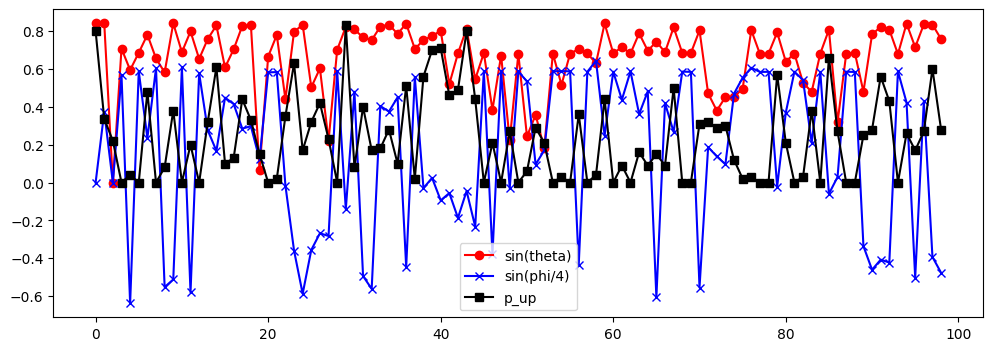

In [71]:
state=32
plt.figure(figsize=(12,4))
plt.plot(np.sin(X[state,:,0]),'o-r',label='sin(theta)')
plt.plot(np.sin(X[state,:,1]),'x-b',label='sin(phi/4)')
plt.plot(X[state,:,2],'s-k',label='p_up')
plt.legend()
plt.show()

In [72]:
# Set the percentage of data to use for validation
validation_split = 0.2

# Determine the number of samples to use for validation
num_validation_samples = int(angles_data.shape[0] * validation_split)

# Split the data into training and validation sets
train_data_angles  = angles_data[:-num_validation_samples]
train_data_banks   = banks_data[:-num_validation_samples]
train_data_weights = weights_data[:-num_validation_samples]

valid_data_angles  = angles_data[-num_validation_samples:]
valid_data_banks   = banks_data[-num_validation_samples:]
valid_data_weights = weights_data[-num_validation_samples:]

In [73]:
# Set batch size
batch_size = 32

# TensorFlow datasets API
train_dataset = tf.data.Dataset.from_tensor_slices((train_data_angles, train_data_banks, train_data_weights)).batch(batch_size)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data_angles, valid_data_banks, valid_data_weights)).batch(batch_size)


In [74]:
#Get the size of the dataset
dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()

# Print the size of the dataset
print("Dataset Size:", dataset_size)

total_data_points = dataset_size * batch_size
print("Total Data Points:", total_data_points)

Dataset Size: 25
Total Data Points: 800


In [75]:
# Check dimensions of the batches in training dataset
for batch_angles, batch_banks, batch_weights in train_dataset.take(1):
    print("Training Batch Shapes:")
    print("Angles Batch Shape:", batch_angles.shape)
    print("Banks Batch Shape:", batch_banks[0,...].shape)
    print("Weights Batch Shape:", batch_weights.shape)

# Check dimensions of the batches in validation dataset
for batch_angles, batch_banks, batch_weights in valid_dataset.take(1):
    print("\nValidation Batch Shapes:")
    print("Angles Batch Shape:", batch_angles.shape)
    print("Banks Batch Shape:", batch_banks.shape)
    print("Weights Batch Shape:", batch_weights.shape)

Training Batch Shapes:
Angles Batch Shape: (32, 99, 5)
Banks Batch Shape: (99, 100, 2, 2)
Weights Batch Shape: (32, 99, 100)

Validation Batch Shapes:
Angles Batch Shape: (32, 99, 5)
Banks Batch Shape: (32, 99, 100, 2, 2)
Weights Batch Shape: (32, 99, 100)


In [76]:
class InfoGain(tf.Module):
    def __init__(self):
        super(InfoGain, self).__init__()

    def information_gain(self, angles, bank_particles, weights):
        result = tf.numpy_function(self.information_gain_py, [angles, bank_particles, weights], tf.float64)
        return tf.convert_to_tensor(result, dtype=tf.float64)

    def information_gain_py(self, angles,bank_particles,weights):

        best_guess=np.array(np.einsum('ijkl,ij->ikl',bank_particles,weights))
        return self.adaptive_cost_func(angles,bank_particles,weights,best_guess)

    def adaptive_cost_func(self, angles,rhoBank,weights,bestGuess):

        # Crates projector from angles
        povm=self.angles_to_single_qubit_POVM(angles)
        # Computes the entropy of prior and posterior distributions. See 10.1103/PhysRevA.85.052120 for more details.
        K=self.Shannon_entropy(np.einsum('nijk,nkj->ni',povm,bestGuess))
        J=self.Shannon_entropy(np.einsum('nijk,nlkj->nil',povm,rhoBank))
        # Returns the negative values such that it becomes a minimization problem rather than maximization problem.
        return np.real(K-np.einsum("ij,ij->i",J,weights))

    #def Shannon_entropy(self, prob):
    #    return np.real(np.sum(-(prob*np.log2(prob)),axis=1))

    def Shannon_entropy(self, prob):
        epsilon = 1e-10  # Small epsilon value to avoid division by zero
        prob    = np.maximum(prob, epsilon)  # Replace zeros with epsilon
        return np.real(np.sum(-(prob * np.log2(prob)), axis=1))

    def angles_to_single_qubit_POVM(self, angles):
        """
        Function is now vectorized in 0th index.
        Takes in measurement angles as dictionaries and returns the spin POVM as 2x2x2 complex array .
        For single qubit only.
        """
        up_state_vector=np.array([np.cos(angles[:,0]/2),np.exp(1j*angles[:,1])*np.sin(angles[:,0]/2)],dtype=complex)
        up_POVM=np.einsum("in,jn->nij",up_state_vector,up_state_vector.conj())
        return np.einsum('injk->nijk',np.array([up_POVM[:],np.eye(2)-up_POVM[:]],dtype=complex))


In [98]:
def test_loss(y_true, y_pred):

    return tf.reduce_mean(tf.keras.losses.mean_squared_error(y_true, y_pred))


In [88]:
def custom_loss(y_true, y_pred, banks, weights, lambda_weight=0.0, replace_inf_value=100):

    # Calculate the mean loss over batch
    mse_target = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_true, y_pred))

    info_gain = InfoGain()

    true_info_gains = info_gain.information_gain(y_true, banks, weights)
    pred_info_gains = info_gain.information_gain(y_pred, banks, weights)

    loss_infoGain = 1e4 * tf.math.abs(pred_info_gains - true_info_gains)

    # Check for infinity in the total_loss tensor
    loss_infoGain = tf.where(tf.math.is_finite(loss_infoGain), loss_infoGain, replace_inf_value)

    # Calculate the mean loss over batch
    loss_infoGain = tf.reduce_mean(loss_infoGain)


    #lambda_weight = tf.cast(lambda_weight, dtype=mse_target.dtype)

    #total_loss = lambda_weight * mse_target + (1.0 - lambda_weight) * loss_infoGain

    return loss_infoGain


In [89]:
# Custom Self-Attention Layer
class SelfAttention(tf.keras.layers.Layer):
    '''
      arXiv:1706.03762v7   ---> Scaled Dot-Product Attention
      Input Shape: (batch_size, sequence_length, feature_dim)

      batch_size     : The number of samples in each batch.
      sequence_length: The length of the sequence in each sample.
      feature_dim    : The number of features in each element of the sequence.

      Output Shape: (batch_size, sequence_length, feature_dim)

          The output preserves the same structure as the input.
          For each element in the sequence, the self-attention mechanism computes a
          weighted sum of all elements in the sequence based on their relationships,
          and the output at each position is a combination of these weighted sums.
    '''

    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w_q = self.add_weight(name="w_q", shape=(input_shape[-1], input_shape[-1]), initializer="uniform", trainable=True)
        self.w_k = self.add_weight(name="w_k", shape=(input_shape[-1], input_shape[-1]), initializer="uniform", trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, x):
        q = tf.matmul(x, self.w_q)
        k = tf.matmul(x, self.w_k)
        v = x
        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        output = tf.matmul(attention_scores, v)
        return output


In [90]:
class GraphAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, units, dropout=0.6, alpha=0.2):
        super(GraphAttentionLayer, self).__init__()
        self.units   = units
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.alpha   = alpha

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        #print(input_shape)
        self.W = self.add_weight(shape=(feature_dim, self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.a = self.add_weight(shape=(2 * self.units, 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(GraphAttentionLayer, self).build(input_shape)

    def call(self, nodes, adj_matrix):
        h = tf.matmul(nodes, self.W)
        N = h.shape[1]
        a_input = tf.concat([tf.tile(h, multiples=[1, N, 1]), tf.repeat(h, repeats=N, axis=1)], axis=2)
        a_input = tf.reshape(a_input, (-1, N, N, 2 * self.units))


        e = tf.nn.leaky_relu(tf.matmul(a_input, self.a), alpha=self.alpha)

        e = tf.squeeze(e, axis=-1)

        zero_vec = -9e15 * tf.ones_like(e)
        attention = tf.where(adj_matrix > 0, e, zero_vec)

        # Use a mask to handle sparsity (adj_matrix > 0)
        #mask = tf.cast(tf.math.greater(adj_matrix, 0), dtype=tf.float32)
        #attention = tf.nn.softmax(e * mask, axis=1)

        attention = tf.nn.softmax(attention, axis=2) # compute normalized attention coefficients for each node in the graph
        attention = self.dropout(attention)

        h_prime = tf.matmul(attention, h)

        return tf.keras.activations.elu(h_prime)



In [91]:
class MyModel(tf.keras.Model):
    def __init__(self, dense_units, hidden_dim, out_features, num_heads, final_dense_units=2, dropout=0.6):
        super(MyModel, self).__init__()

        # Dense layer before GAT layers
        self.dense1 = tf.keras.layers.Dense(dense_units, activation='relu')

        # GAT layers
        self.attentions = [GraphAttentionLayer(hidden_dim, dropout=dropout) for _ in range(num_heads)]
        self.out_att    =  GraphAttentionLayer(out_features, dropout=dropout)

        # Final dense layer
        self.dense2 = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(final_dense_units, activation=None)
        ])


    def call(self, inputs, adj_matrix):
        x = self.dense1(inputs)
        attention_outputs = [att(x, adj_matrix) for att in self.attentions]
        x = tf.concat(attention_outputs, axis=-1)
        x = self.out_att(x, adj_matrix)
        x = self.dense2(x)
        #print(x.shape)
        return x

In [92]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [99]:
model = MyModel(dense_units=12, hidden_dim=8, out_features=2, num_heads=1)
model.compile(optimizer=optimizer, loss=test_loss)

In [94]:
#test
num_nodes   = 50
in_features = 3
out_features_gat  = 3
batch_size = 32

adj_matrix = tf.ones((num_nodes, num_nodes))
features   = tf.random.normal(( 32, num_nodes, in_features))


# Forward pass
output = model(features, adj_matrix)
print('==>',output.shape)

==> (32, 2)


In [95]:
checkpoint_path = "/content/drive/MyDrive/SL_data/model_checkpoint.h5"
early_stopping   = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)


In [103]:
@tf.function(reduce_retracing=True)
def train_step(batch_angles, batch_banks, batch_weights, predic_index=50):
    total_loss = 0
    adj_matrix = tf.ones((predic_index, predic_index))

    with tf.GradientTape() as tape:
        input_angles = batch_angles[:, :predic_index, :3]
        true_angle   = batch_angles[:,  predic_index, 3:]

        pred_angle = model(input_angles, adj_matrix)
        loss  = test_loss(true_angle, pred_angle)
        #loss       = custom_loss(true_angle, pred_angle, batch_banks[:,predic_index,:,:,:], batch_weights[:,predic_index,:])

    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss


@tf.function(reduce_retracing=True)
def validate_step(batch_angles, batch_banks, batch_weights, predic_index=50):
    adj_matrix = tf.ones((predic_index, predic_index))
    input_angles  = batch_angles[:, :predic_index, :3]
    true_angle    = batch_angles[:,  predic_index, 3:]

    pred_angle = model(input_angles, adj_matrix)
    loss  = test_loss(true_angle, pred_angle)
    #loss = custom_loss(pred_angle, true_angle, batch_banks[:,predic_index,:,:,:], batch_weights[:,predic_index,:])

    return loss

In [105]:
# Initialize lists to store training metrics
train_loss_history  = []
valid_loss_history  = []
epochs              = 10


for epoch in range(epochs):

    total_train_loss = 0
    for batch_index, (batch_angles, batch_banks, batch_weights) in enumerate(train_dataset):
        print(f"Training Batch Index: {batch_index + 1} / {len(train_dataset)}", end='\r')
        loss = train_step(batch_angles, batch_banks, batch_weights)
        total_train_loss += loss.numpy()

    total_valid_loss = 0
    for batch_angles, batch_banks, batch_weights in valid_dataset:
        loss = validate_step(batch_angles, batch_banks, batch_weights)
        total_valid_loss += loss.numpy()

    avg_train_loss = total_train_loss / len(train_dataset)
    avg_valid_loss = total_valid_loss / len(valid_dataset)

    train_loss_history.append(avg_train_loss)
    valid_loss_history.append(avg_valid_loss)

    print(f'Epoch {epoch + 1}/{epochs}, '
          f'Training   Loss: {avg_train_loss:.6f}, '
          f'Validation Loss: {avg_valid_loss:.6f}, ')


    #Evaluate early stopping criteria
    #if early_stopping.on_epoch_end(epoch + 1, {'val_loss': avg_valid_loss}):
    #    print("Early stopping triggered.")
    #    break

Epoch 1/10, Training   Loss: 0.120978, Validation Loss: 0.113505, 
Epoch 2/10, Training   Loss: 0.118681, Validation Loss: 0.112664, 
Epoch 3/10, Training   Loss: 0.117968, Validation Loss: 0.111984, 
Epoch 4/10, Training   Loss: 0.117302, Validation Loss: 0.111063, 
Epoch 5/10, Training   Loss: 0.116230, Validation Loss: 0.109370, 
Epoch 6/10, Training   Loss: 0.114615, Validation Loss: 0.106997, 
Epoch 7/10, Training   Loss: 0.111999, Validation Loss: 0.102189, 
Epoch 8/10, Training   Loss: 0.109045, Validation Loss: 0.096785, 
Epoch 9/10, Training   Loss: 0.107306, Validation Loss: 0.093849, 
Epoch 10/10, Training   Loss: 0.106750, Validation Loss: 0.092381, 


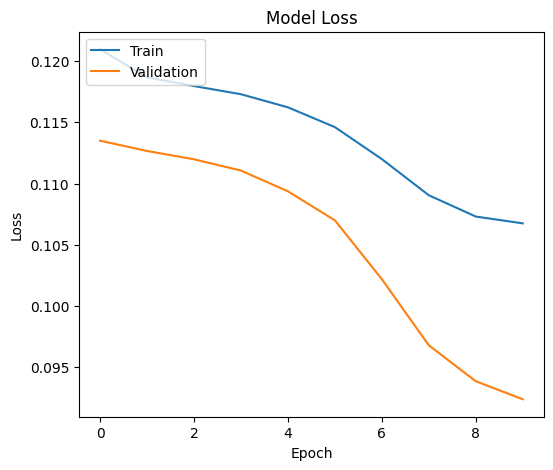

In [106]:
# Plot the training history
plt.figure(figsize=(6, 5))
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()